# Plot Sentinel-2 mosaic from August 2019
Also, test out the flowline extraction scripts, from `flow_line.py`

Script written by Tim Bartholomaus in January 29, 2021

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import rasterio as rio
from rasterio.windows import Window 


import flow_line as fl

%matplotlib widget


In [2]:
# This Sentinel 2 mosaic from August 2019 is described here, and use should be cited to this paper:
#  MacGregor et al., 2020, in J Glac, https://doi.org/10.1017/jog.2020.62
S2_path = 'http://its-live-data.jpl.nasa.gov.s3.amazonaws.com/rgb_mosaics/GRE2/Greenlandmedian_Aug_2019.vrt'

S2rio = rio.open(S2_path)

In [3]:
# Raster is 3 bands of x dim: 160,000 by y dim: 270,000
# Be careful, because you can easily lock up your computer if you try and plot this all at once!
# pixel size is 10 m by 10 m.

print(S2rio.count)
print(S2rio.width)
print(S2rio.height)
print(S2rio.bounds)
print(S2rio.transform)
print(S2rio.crs)

3
160000
270000
BoundingBox(left=-700000.0, bottom=-3400000.0, right=900000.0, top=-700000.0)
| 10.00, 0.00,-700000.00|
| 0.00,-10.00,-700000.00|
| 0.00, 0.00, 1.00|
EPSG:3413


In [4]:
# I'm pulling these CRS 3413 coordinates from QGIS, or some other mapping application
Rink_location = (-210000, -1981000) # x, y Geographic coords in meters relative to CRS 3413
Helheim_location = (299000, -2573000) # x, y Geographic coords in meters relative to CRS 3413
Jakobshavn_location = (-163000, -2281000)

center_point = Rink_location
view_span = 50*1000 # m  As written, this script creates a square view of the S2 mosaic, 
                    #    with width and height of linear dimension view_span, centered on center_point.
                    #    If this is too big, it might make the program hang.

toprow, leftcol = S2rio.index(center_point[0]-view_span/2, center_point[1]-view_span/2)  # Find image indices that bound the region of interest
bottomrow, rightcol = S2rio.index(center_point[0]+view_span/2 , center_point[1]+view_span/2)

In [6]:
vel_field = fl.load_vel_field()

starting_point = np.array([-180, -1980]) # Rink  coordinates in km
# starting_point = np.array([303, -2576]) # Helheim
# starting_point = np.array([-155, -2274]) # Jakobshavn

import time

tic = time.perf_counter()
flowline = fl.flowline(vel_field, starting_point)

toc = time.perf_counter()
print(f"Flowline identified in {toc - tic:0.4f} seconds")


Short Flowline - starting point in region:  West
Factor = 23.7; Max line spacing = 5.92 km; Run time = 0.4 s
Factor = 1.1; Max line spacing = 0.28 km; Run time = 37.5 s
Factor = 1.0; Max line spacing = 0.25 km; Run time = 50.0 s
Maximum point spacing on flowline is 250.0 m, and resolution of the original velocity dataset is 250.0 m.
Flowline identified in 87.9495 seconds


<Figure size 7.2x7.2 with 0 Axes>

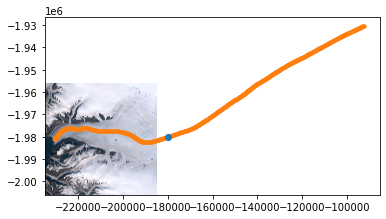

In [7]:
S2img = np.empty( (toprow - bottomrow, rightcol-leftcol, 3) )
# Read in each of the three RGB bands, but only from within a 
S2img[:,:,0] = S2rio.read(1, window=Window(leftcol, bottomrow, rightcol-leftcol, toprow - bottomrow) )
S2img[:,:,1] = S2rio.read(2, window=Window(leftcol, bottomrow, rightcol-leftcol, toprow - bottomrow) )
S2img[:,:,2] = S2rio.read(3, window=Window(leftcol, bottomrow, rightcol-leftcol, toprow - bottomrow) )

extent = (center_point[0]-view_span/2, center_point[0]+view_span/2 , center_point[1]-view_span/2, center_point[1]+view_span/2)
plt.figure()
plt.imshow(S2img/255, extent=extent) # Divide by 255 to scale all RGB pixel values from [0,1]


# Plot the flowline and starting_point over the top of the S2 image
plt.plot(flowline[:,0]*1000, flowline[:,1]*1000, '.-',color='C1')
plt.plot(starting_point[0]*1000, starting_point[1]*1000, 'o',color='C0')

# plt.xlim([-231000, -180000])

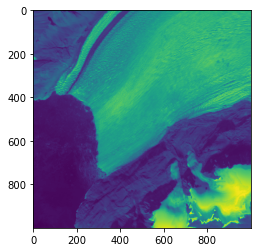

In [26]:
#S2red = S2rio.read(1, window=Window(leftcol, bottomrow, rightcol-leftcol, toprow - bottomrow) )



#np.shape(S2rio.read(1, window=Window(0, 0, 512, 256) ))
#plt.imshow(S2rio.read(1, window=Window(4e4, 4e4, 4.01e4, 4.01e4) ))

#plt.imshow(S2rio.read(1, window=Window(toprow, leftcol, bottomrow, rightcol) ))
plt.imshow(S2rio.read(1, window=Window(leftcol, bottomrow, rightcol-leftcol, toprow - bottomrow) ))

5